# Redes neuronales recurrentes

- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification


<img src="../img/rnn.png" width="500"/>

__Imagen tomada de Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.__

## 1.- Conjuntos de entrenamiento y validación

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./cyberbullying_tweets.csv')   

In [3]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [5]:
# Contar elementos por clase
count = df['cyberbullying_type'].value_counts()
count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df= train_test_split(df, test_size = 0.15, random_state = 123)

In [7]:
train_df['cyberbullying_type'].value_counts()

cyberbullying_type
not_cyberbullying      6826
gender                 6821
ethnicity              6777
age                    6763
religion               6743
other_cyberbullying    6608
Name: count, dtype: int64

## 2.- Preprocesamiento

In [8]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

# Usamos la función map() para reemplazar cada etiqueta con su valor entero correspondiente
train_df['cyberbullying_type'] = train_df['cyberbullying_type'].replace(labels_dict)
val_df['cyberbullying_type'] = val_df['cyberbullying_type'].replace(labels_dict)

train_df.head()

,tweet_text,cyberbullying_type
32620,If you’re in college and still posting about t...,4
9173,"but, there is still the dolly magazine model c...",1
1466,Why am I disappointed?,0
32887,What was the conversation was leading up to th...,4
15856,"“faces up to three years in prison” , “getting...",1


- Verifica cadenas vacias

In [9]:
train_df['tweet_text'].isna().sum()

0

- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
train_df['tweet_text'] = train_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
train_df.head()

,tweet_text,cyberbullying_type
32620,if you’re in college and still posting about t...,4
9173,but there is still the dolly magazine model co...,1
1466,why am i disappointed,0
32887,what was the conversation was leading up to th...,4
15856,“faces up to three years in prison” “getting ...,1


In [12]:
val_df['tweet_text'] = val_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
val_df.head()

,tweet_text,cyberbullying_type
22180,too true their radical anti family anti bible ...,2
1399,this book was published in 2008,0
14950,rt strubbestition im not sexist but personal o...,1
17013,dianh4 exposefalsehood who else are we suppose...,2
45351,lmao u dumb rt k11agee what is the ciaa colore...,5


## 2.- Pipeline

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras import layers 
import re

X_train = train_df['tweet_text'].values
y_train = train_df['cyberbullying_type'].values

X_val = val_df['tweet_text'].values
y_val = val_df['cyberbullying_type'].values

In [14]:
len(X_train), len(X_val)

(40538, 7154)

In [15]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

for text in raw_train_ds.take(1):
    print(text)

(<tf.Tensor: shape=(), dtype=string, numpy=b'if you\xe2\x80\x99re in college and still posting about the girl you had \xe2\x80\x9cbeef\xe2\x80\x9d with and bullied in high school on an insta spam page you\xe2\x80\x99re straight up trash move tf on sis'>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)


In [16]:
# Tamaño de vocabulario
vocab_size = 10000
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='int')

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [17]:
# Define a function to convert the label to a one-hot encoding
def convert_label_to_one_hot(text, label):
    one_hot_label = tf.one_hot(label, 6)
    return text, one_hot_label

# Apply the function to the dataset using map()
raw_train_ds = raw_train_ds.map(convert_label_to_one_hot)
raw_val_ds = raw_val_ds.map(convert_label_to_one_hot)

In [18]:
batch_size = 64
train_ds = raw_train_ds.shuffle(33384).batch(batch_size)
val_ds = raw_val_ds.batch(batch_size)

In [19]:
for inp, target in train_ds.take(1):
    print(inp, target)

tf.Tensor(
[b'watchobserve camillehughes16 anthfieg1 getting a job and integrating is the individuals problem not the governments'
 b'typical twitter left wing haters we know they support the radical muslim stuff they ban christians and conservativesnorthing new'
 b'angelalynn im saying black ppl are disgusting d i would know i have a few niggers in my family d'
 b'as do i which is why i support the first amendment with respect to the establishment of religion i do know that about radical islam but don\xe2\x80\x99t christians share the same belief the doj is currently considering whether christian employers can mandate that women wear skirts 12'
 b'anyway all im saying is its all or none if we going to joke about aids rape gay mental disorders body shapes jobs degrees so be it'
 b'goodwoodnyc obviously your the dumbass for not knowing where the fuck it is bitchhhhh  dumb ass nigger  smh'
 b'rt deanowen118 yesyouresexist phildoran21 typical woman sticking her nose in'
 b'rudawenglish ut

In [20]:
vectorize_layer(inp)

<tf.Tensor: shape=(64, 54), dtype=int64, numpy=
array([[5820, 5733,    1, ...,    0,    0,    0],
       [1337,  221,  350, ...,    0,    0,    0],
       [   1,   50,  191, ...,    0,    0,    0],
       ...,
       [   2,  161, 1741, ...,    0,    0,    0],
       [  73,  175, 2738, ...,    0,    0,    0],
       [ 421,  125, 4459, ...,    0,    0,    0]])>

## 3.- Modelo
### RNN simple

RNN:
\begin{equation}
h_t = f(Wx_t + Uh_{t-1} + b)
\end{equation}

In [21]:
epochs = 10
lr = 0.001

In [22]:
rnn = Sequential([
  vectorize_layer,
  layers.Embedding(vocab_size, 128, name="embedding"),
  layers.SimpleRNN(128),
  layers.Dense(16, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(6)
])

opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [23]:
rnn.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=['accuracy'])

In [24]:
rnn(inp)

<tf.Tensor: shape=(64, 6), dtype=float32, numpy=
array([[-2.26814952e-02, -1.01329215e-01,  1.03954272e-02,
         1.27813682e-01,  6.82731569e-02, -1.10480726e-01],
       [-9.02203470e-03, -8.21506381e-02, -6.59239590e-02,
         8.70207697e-02, -7.68397050e-03, -8.03053901e-02],
       [-3.52809019e-02, -1.12221360e-01, -2.44859513e-02,
         1.15790620e-01,  2.57313941e-02, -1.04408160e-01],
       [ 1.68709084e-01, -2.38866732e-02, -1.45579174e-01,
         4.35006879e-02,  6.81654736e-02, -1.15028404e-01],
       [-2.67542657e-02, -7.73955509e-02, -1.13496855e-02,
         1.12816736e-01,  1.45362848e-02, -1.07416600e-01],
       [-1.37656918e-02, -8.25702921e-02, -4.99851368e-02,
         9.31052566e-02, -1.49880175e-03, -6.79031760e-02],
       [-1.71133913e-02, -6.92142397e-02, -2.64255945e-02,
         8.63202512e-02,  2.59897532e-03, -6.86430708e-02],
       [ 1.44796846e-02, -3.74794677e-02, -1.36361294e-03,
         1.01875454e-01,  2.48797406e-02, -3.06590851e-02],

In [25]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                        

In [26]:
history = rnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
634/634 [==============================] - 28s 41ms/step - loss: 1.7954 - accuracy: 0.1694 - val_loss: 1.7916 - val_accuracy: 0.1676
Epoch 2/10
634/634 [==============================] - 12s 19ms/step - loss: 1.7986 - accuracy: 0.1688 - val_loss: 1.7964 - val_accuracy: 0.1654
Epoch 3/10
634/634 [==============================] - 10s 16ms/step - loss: 1.7935 - accuracy: 0.1646 - val_loss: 1.7929 - val_accuracy: 0.1512
Epoch 4/10
634/634 [==============================] - 10s 15ms/step - loss: 1.7920 - accuracy: 0.1687 - val_loss: 1.7919 - val_accuracy: 0.1570
Epoch 5/10
634/634 [==============================] - 9s 15ms/step - loss: 1.7919 - accuracy: 0.1662 - val_loss: 1.7919 - val_accuracy: 0.1655
Epoch 6/10
634/634 [==============================] - 9s 14ms/step - loss: 1.7918 - accuracy: 0.1666 - val_loss: 1.7921 - val_accuracy: 0.1610
Epoch 7/10
634/634 [==============================] - 9s 15ms/step - loss: 1.7918 - accuracy: 0.1686 - val_loss: 1.7919 - val_accuracy: 0.

### LSTM

LSTM:

\begin{align}
i_t & = \sigma(W^ix_t + U^ih_{t-1} + b^i) \\
f_t & = \sigma(W^fx_t + U^fh_{t-1} + b^f) \\
o_t & = \sigma(W^ox_t + U^oh_{t-1} + b^o) \\
g_t & = \text{tanh}(W^gx_t + U^gh_{t-1} + b^g) \\
c_t & = f_t \odot c_{t-1} + i_t \odot g_t\\
h_t & = o_t \odot \text{tanh}(c_t) \\
\end{align}

In [27]:
lstm = Sequential([
  vectorize_layer,
  layers.Embedding(vocab_size, 128, name="embedding"),
  layers.LSTM(128),
  layers.Dense(16, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(6)
])

opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [28]:
lstm.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
lstm(inp)

<tf.Tensor: shape=(64, 6), dtype=float32, numpy=
array([[ 0.0005188 , -0.00818101, -0.01168109,  0.02109315, -0.00928995,
        -0.0201247 ],
       [ 0.0005471 , -0.00816265, -0.01167257,  0.02111037, -0.00928508,
        -0.02012055],
       [ 0.00057869, -0.00816122, -0.01171008,  0.02110865, -0.00927903,
        -0.02008634],
       [ 0.00231167, -0.00549055, -0.01031002,  0.01971156, -0.00947667,
        -0.0163054 ],
       [ 0.0008036 , -0.00806   , -0.01173102,  0.02117559, -0.00923703,
        -0.01997835],
       [ 0.0005478 , -0.00815175, -0.01167312,  0.0210954 , -0.00927698,
        -0.02009432],
       [ 0.00049894, -0.00817821, -0.0116771 ,  0.02107974, -0.0093001 ,
        -0.02012012],
       [ 0.00048773, -0.00818575, -0.01167513,  0.02107684, -0.00930375,
        -0.02012983],
       [ 0.0005054 , -0.00817948, -0.01167461,  0.02108784, -0.00929565,
        -0.02012701],
       [-0.00183748, -0.00700448, -0.0022529 ,  0.0015334 , -0.0025258 ,
        -0.00694682],
 

In [30]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 16)                2064      
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                      

In [31]:
history = lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
634/634 [==============================] - 18s 26ms/step - loss: 1.3322 - accuracy: 0.3179 - val_loss: 1.3389 - val_accuracy: 0.3214
Epoch 2/10
634/634 [==============================] - 6s 9ms/step - loss: 1.2737 - accuracy: 0.3576 - val_loss: 1.0810 - val_accuracy: 0.4860
Epoch 3/10
634/634 [==============================] - 5s 8ms/step - loss: 0.8548 - accuracy: 0.6409 - val_loss: 0.6138 - val_accuracy: 0.7455
Epoch 4/10
634/634 [==============================] - 5s 8ms/step - loss: 0.5212 - accuracy: 0.7816 - val_loss: 0.4763 - val_accuracy: 0.8032
Epoch 5/10
634/634 [==============================] - 6s 9ms/step - loss: 0.4037 - accuracy: 0.8321 - val_loss: 0.4547 - val_accuracy: 0.8134
Epoch 6/10
634/634 [==============================] - 5s 8ms/step - loss: 0.3381 - accuracy: 0.8651 - val_loss: 0.4464 - val_accuracy: 0.8211
Epoch 7/10
634/634 [==============================] - 5s 7ms/step - loss: 0.2918 - accuracy: 0.8874 - val_loss: 0.4787 - val_accuracy: 0.8195
Epoc

## 4.- Evaluación

In [32]:
rnn.evaluate(val_ds)
lstm.evaluate(val_ds)

112/112 [==============================] - 0s 3ms/step - loss: 0.5586 - accuracy: 0.8195


[0.5585957169532776, 0.8195415139198303]

In [33]:
x_test, y_test = next(iter(val_ds))
x_test.shape, y_test.shape

(TensorShape([64]), TensorShape([64, 6]))

In [34]:
lstm.layers

In [35]:
words = 'bad good hate happy love scared friend sad alive family confident fight live funny best great amazing'
ids = lstm.layers[0]([words])
embeddings = lstm.layers[1](ids)
embeddings

<tf.Tensor: shape=(1, 17, 128), dtype=float32, numpy=
array([[[-0.10111269,  0.02074852, -0.06578368, ..., -0.052722  ,
         -0.10961329,  0.04738013],
        [ 0.002458  ,  0.12131011,  0.06843492, ..., -0.07005006,
          0.01830205,  0.00816528],
        [-0.01269575, -0.02408076, -0.00037404, ...,  0.02127643,
         -0.05716956,  0.13108772],
        ...,
        [ 0.06578471,  0.06644186,  0.07879839, ...,  0.03635463,
          0.02629028, -0.08329534],
        [ 0.03135646,  0.00681779,  0.10884069, ...,  0.00868514,
          0.13392735, -0.1521378 ],
        [-0.0262137 ,  0.03197402, -0.01656346, ..., -0.05584345,
         -0.05704683,  0.0848968 ]]], dtype=float32)>

- Visualización de los vectores aprendidos

(17, 2)


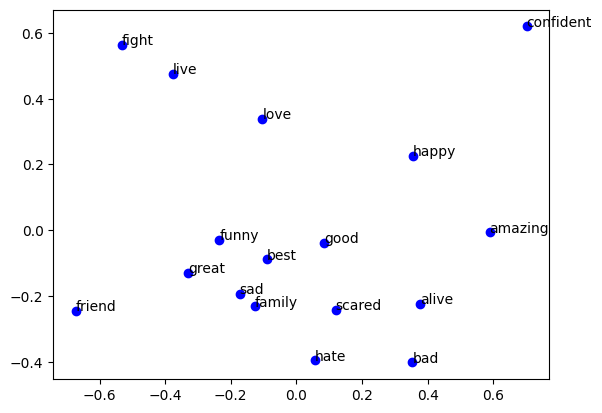

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings[0])
print(pca_embeddings.shape)

# Plot embeddings using matplotlib
fig, ax = plt.subplots()
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words.split()):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))
    
plt.show()